In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [11]:
fees = pd.read_csv('./data/extract - fees - data analyst - .csv')
cash_request = pd.read_csv('./data/extract - cash request - data analyst.csv')

In [12]:
merged_df = fees.merge(
    cash_request, left_on="cash_request_id", right_on="id", suffixes=("_fees", "_cash")
)

In [13]:
date_cols = ["reimbursement_date", "money_back_date"]
for col in date_cols:
    merged_df[col] = pd.to_datetime(merged_df[col], errors='coerce')

# Create a new feature: repayment delay in days
merged_df["repayment_delay"] = (merged_df["money_back_date"] - merged_df["reimbursement_date"]).dt.days

# Set the repayment_delay to -1 when we couldn't calculate it. 
merged_df["repayment_delay"].fillna(-1, inplace=True)


In [14]:
# Define segmentation based on repayment behavior
def categorize_repayment(row):
    '''
         "Defaulter" refers to a customer who has not repaid the money at all
         "Late Payer" refers to a customer who returned the money after the expected reimbursement date.
    '''
    if pd.isna(row["money_back_date"]):
        return "Defaulter"
    elif row["money_back_date"] <= row["reimbursement_date"]:
        return "On-time Payer"
    else:
        return "Late Payer"

In [15]:
merged_df["Repayment_Status"] = merged_df.apply(categorize_repayment, axis=1)

In [16]:
# Display the segmented data
print(merged_df[["cash_request_id", "reimbursement_date", "money_back_date", "Repayment_Status" ,"repayment_delay"]].head())

   cash_request_id        reimbursement_date           money_back_date  \
0          14941.0 2020-10-01 22:00:00+00:00 2020-10-06 22:00:00+00:00   
1          11714.0 2020-09-07 22:00:00+00:00                       NaT   
2          23371.0 2020-11-04 22:00:00+00:00                       NaT   
3          26772.0 2020-11-11 23:51:00+00:00 2020-11-17 23:00:00+00:00   
4          19350.0 2020-10-30 11:00:00+00:00                       NaT   

  Repayment_Status  repayment_delay  
0       Late Payer              5.0  
1        Defaulter             -1.0  
2        Defaulter             -1.0  
3       Late Payer              5.0  
4        Defaulter             -1.0  


In [17]:
from sklearn.ensemble import IsolationForest
# Select features for anomaly detection
features = ["total_amount", "amount", "repayment_delay"]
merged_df.dropna(subset=features, inplace=True)
X = merged_df[["total_amount", "amount", "repayment_delay"]]

# Train Isolation Forest for anomaly detection
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
merged_df["Anomaly_Score"] = iso_forest.fit_predict(X)

# Label anomalies (-1 means an anomaly)
merged_df["Anomaly"] = merged_df["Anomaly_Score"].apply(lambda x: "Anomalous" if x == -1 else "Normal")

# Display the segmented data with anomaly detection
print(merged_df[["cash_request_id", "reimbursement_date", "money_back_date", "repayment_delay", "Repayment_Status", "Anomaly"]].head())

ModuleNotFoundError: No module named 'sklearn'

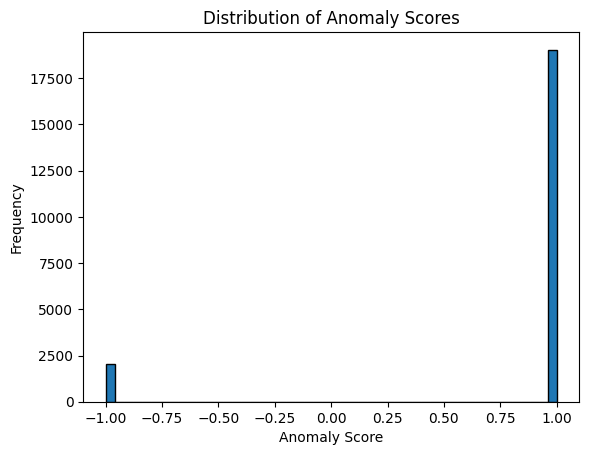

In [10]:
import matplotlib.pyplot as plt

plt.hist(merged_df["Anomaly_Score"], bins=50, edgecolor='black')
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores")
plt.show()

In [11]:
print(merged_df["Anomaly"].value_counts(normalize=True) * 100)


Anomaly
Normal       90.416489
Anomalous     9.583511
Name: proportion, dtype: float64


In [12]:
anomalies = merged_df[merged_df["Anomaly"] == "Anomalous"]
print(anomalies[["cash_request_id", "total_amount", "repayment_delay", "Repayment_Status"]].head(50))


     cash_request_id  total_amount  repayment_delay Repayment_Status
16           26565.0           5.0             -1.0        Defaulter
29           22251.0           5.0              3.0       Late Payer
44           12952.0           5.0             -1.0        Defaulter
55           26575.0           5.0             36.0       Late Payer
70           22977.0           5.0             15.0       Late Payer
79           26494.0           5.0              4.0       Late Payer
94           14814.0           5.0             28.0       Late Payer
106          14924.0           5.0             31.0       Late Payer
115          14093.0           5.0             -1.0        Defaulter
126          18606.0           5.0              3.0       Late Payer
140          22139.0           5.0             -1.0        Defaulter
143           3229.0           5.0            157.0       Late Payer
146          26119.0           5.0              6.0       Late Payer
157          18606.0           5.0

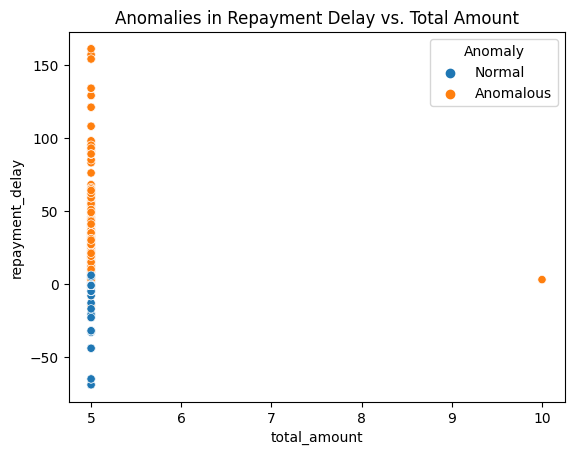

In [13]:
import seaborn as sns

sns.scatterplot(data=merged_df, x="total_amount", y="repayment_delay", hue="Anomaly")
plt.title("Anomalies in Repayment Delay vs. Total Amount")
plt.show()

In [14]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
merged_df["LOF_Anomaly_Score"] = lof.fit_predict(X)

print(merged_df["LOF_Anomaly_Score"].value_counts())  # Compare with Isolation Forest results

LOF_Anomaly_Score
 1    20347
-1      710
Name: count, dtype: int64


In [15]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)  # Adjust contamination
merged_df["Anomaly_Score"] = iso_forest.fit_predict(X)

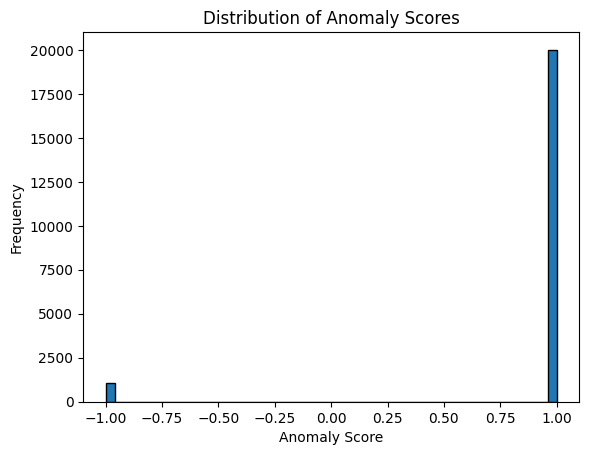

In [16]:
import matplotlib.pyplot as plt

plt.hist(merged_df["Anomaly_Score"], bins=50, edgecolor='black')
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores")
plt.show()

In [17]:
print(merged_df["Anomaly"].value_counts(normalize=True) * 100)

Anomaly
Normal       90.416489
Anomalous     9.583511
Name: proportion, dtype: float64


In [18]:
anomalies = merged_df[merged_df["Anomaly"] == "Anomalous"]
print(anomalies[["cash_request_id", "total_amount", "repayment_delay", "Repayment_Status"]].head(50))

     cash_request_id  total_amount  repayment_delay Repayment_Status
16           26565.0           5.0             -1.0        Defaulter
29           22251.0           5.0              3.0       Late Payer
44           12952.0           5.0             -1.0        Defaulter
55           26575.0           5.0             36.0       Late Payer
70           22977.0           5.0             15.0       Late Payer
79           26494.0           5.0              4.0       Late Payer
94           14814.0           5.0             28.0       Late Payer
106          14924.0           5.0             31.0       Late Payer
115          14093.0           5.0             -1.0        Defaulter
126          18606.0           5.0              3.0       Late Payer
140          22139.0           5.0             -1.0        Defaulter
143           3229.0           5.0            157.0       Late Payer
146          26119.0           5.0              6.0       Late Payer
157          18606.0           5.0